# 2 Descriptors

The descriptor summarizes the local structure around keypoints.

There are many available classical descriptors and there are learned ones available.

One of the powerful ones is a SIFT descriptor.

Here we implement it only partially.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load an images
image_color = np.asarray(Image.open('data/mountain_1.jpg'), dtype=np.float32) / 255.

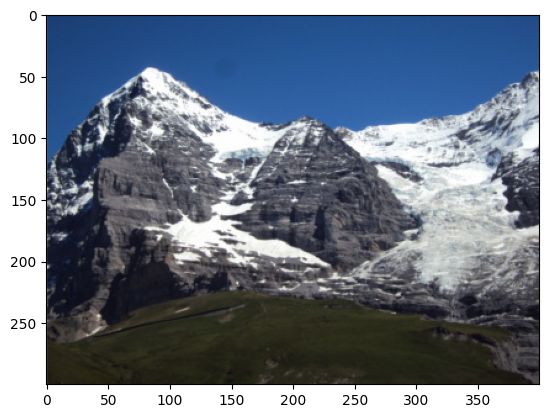

In [2]:
plt.figure()
plt.imshow(image_color)

In [3]:
# Here we have two colored images, but as before, algorithms work on grayscale images.
# We can convert the images to grayscale using the formula:
# grayscale = 0.2989 * red + 0.5870 * green + 0.1140 * blue

def rgb2gray(rgb: np.ndarray) -> np.ndarray:
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

image = rgb2gray(image_color)


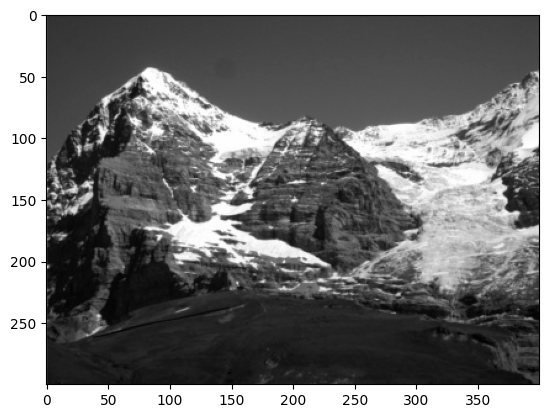

In [4]:
plt.figure()
plt.imshow(image, cmap='gray')

As a first step let's pre-compute keypoints.

In [ ]:
from src.compute_corners import compute_corners, CornerCriterion

corners_image = compute_corners(image, CornerCriterion.SHI_TOMASI, 0.2)
print(corners_image.shape)

plt.figure()
plt.imshow(image, cmap="grey")
plt.plot(corners_image[:,0], corners_image[:,1], 'rx', markersize=5)

NameError: name 'image_1' is not defined

## SIFT-Descriptor

SIFT-descriptor is computed around keypoint on a 16x16 image patch around keypoint. We create a histogram of oriented gradients.

SIFT by default uses difference of Gaussians for keypoint detection, but here we will continue reusing points detected by using structure matrix.

<img src="doc/sift_descriptor.png" width="400" />

We first need to compute gradience of an image again. Then to compute magnitude and orientation of a vector we will use standard formulas.

For example:
Given a vector $x = \begin{bmatrix} 1 & 2 \end{bmatrix}^T$ we can compute magnitude of a vector as $|x| = \sqrt{1^2 + 2^2} \approx 2.24$, the rotation angle of a vector is computed using $\text{atan2}$ and it is $\theta = \text{atan2}(y,x) = \text{atan2}(2, 1) \approx 63.43 \text{deg}$

<img src="doc/vector_example.png" width="400" />

We will treat $Ix$ and $Iy$ that we compute from gradients as $x$ and $y$ in this example. It will give us correspondingly local orientations and magnitudes of image gradient. 


In [ ]:
import numpy as np
from PIL import Image
import scipy.ndimage as ndimage
from src.gaussian_kernel import gaussian_kernel
from src.sobel_kernel import sobel_kernel_Dx, sobel_kernel_Dy
from src.utils import rgb2gray

# Initialize kernels
G = gaussian_kernel(3, 0.5)
Dx = sobel_kernel_Dx()
Dy = sobel_kernel_Dy()

Kx = ndimage.convolve(G, Dx)
Ky = ndimage.convolve(G, Dy)

# Compute gradients
Ix = ndimage.convolve(image, Kx)
Iy = ndimage.convolve(image, Ky)

# Compute magnitudes and angles of gradients
magnitude = np.sqrt(Ix**2 + Iy**2)
# Atan returns values between -pi and pi
# For binning we want degrees between 0 and 360
orientation = np.rad2deg(np.arctan2(Iy, Ix) + 2*np.pi) % 360

# Verify that our angles are in correct range
assert ( (0. <= orientation) & (orientation <= 360.)).all()

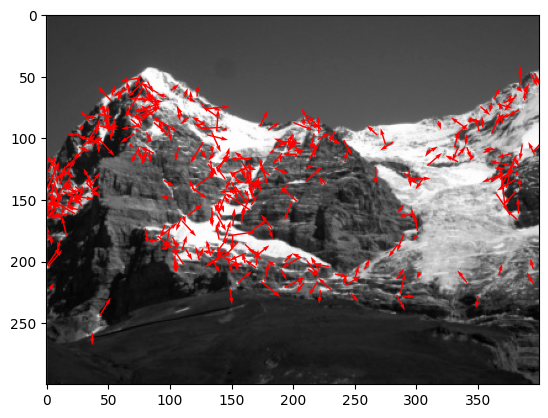

In [ ]:
# Let's visualize the gradients at our keypoints
import matplotlib.pyplot as plt
from src.compute_corners import compute_corners, CornerCriterion

corners = compute_corners(image, CornerCriterion.SHI_TOMASI, 0.2)

dx = Ix[corners[:,1].astype(int), corners[:,0].astype(int)]
dy = Iy[corners[:,1].astype(int), corners[:,0].astype(int)]


plt.figure()
plt.imshow(image, cmap='gray')
plt.quiver(
    corners[:, 0], corners[:, 1],  # X and Y positions
    dx, dy,  # Arrow direction (dx, dy)
    angles="xy", scale_units="xy", scale=2, color="r"
)


(16, 16)
Keypoint coordinates (x, y): 76, 49
Image size (width, height): 400, 300


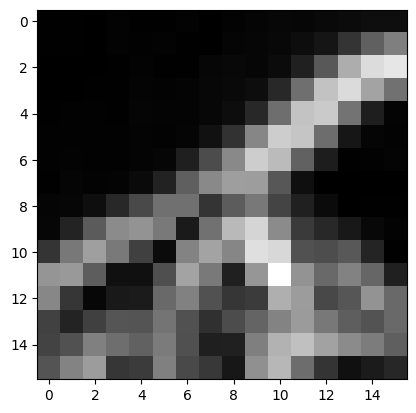

In [ ]:
# Now, let's compute the histograms of gradients for a single keypoint

# Select a single keypoint
x, y = corners[3,0], corners[3,1]

# Cut out a 16x16 patch around it
patch_img = image[y-8:y+8, x-8:x+8]
patch_mag = magnitude[y-8:y+8, x-8:x+8]
patch_ori = orientation[y-8:y+8, x-8:x+8]


# Verify patch size
print(patch_img.shape)

# Plot patch
plt.figure()
plt.imshow(patch_mag, cmap='grey')
print(f"Keypoint coordinates (x, y): {x}, {y}")
print(f"Image size (width, height): {image.shape[1]}, {image.shape[0]}")

(16, 16)


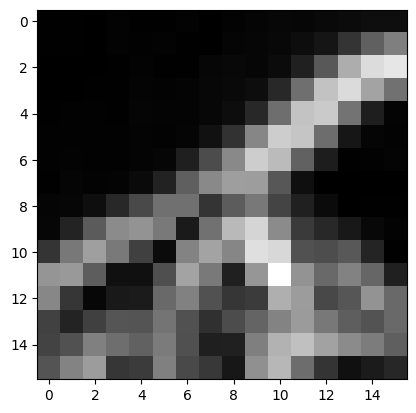

In [ ]:
# So in order to handle the edges, we need to pad the image with zeros before computing the gradients.

padded_img = np.pad(image, 8, constant_values=0)
padded_magnitude = np.pad(magnitude, 8, constant_values=0)
padded_orientation = np.pad(orientation, 8, constant_values=0)

x, y = corners[3,0]+8, corners[3,1] +8
patch_img = padded_img[y-8:y+8, x-8:x+8]
patch_mag = padded_magnitude[y-8:y+8, x-8:x+8]
patch_ori = padded_orientation[y-8:y+8, x-8:x+8]

# Plot patch
plt.figure()
plt.imshow(patch_mag, cmap='grey')

# Verify patch size
print(patch_img.shape)

In [ ]:
# Now we need to compute dominant orientation of the patch

# Compute histogram of gradients


In [ ]:
# Now we compute histograms

descriptor = []
for y in range(0, 16, 4):
    for x in range(0, 16, 4):
        # Cut a 4x4 patch
        subpatch_mag = patch_mag[y:y+4, x:x+4]
        subpatch_ori = patch_ori[y:y+4, x:x+4]

        # Compute histogram
        hist, _ =  np.histogram(subpatch_ori, bins=8, range=(0, 360), weights=subpatch_mag)
        descriptor.append(hist)
descriptor = np.array(descriptor)

# Descriptor normalization
norm = np.linalg.norm(descriptor)
if norm > 0: #prevent divide by zero
  descriptor = descriptor / norm
descriptor[descriptor > 0.2] = 0.2
norm = np.linalg.norm(descriptor)
if norm > 0:
  descriptor = descriptor / norm

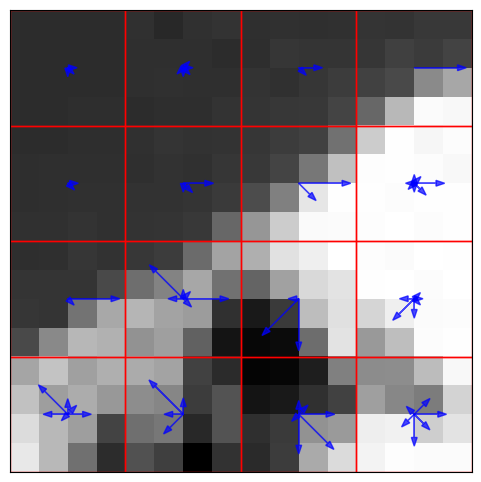

In [ ]:
# Next lets visualize computed descriptor

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2

def visualize_sift_descriptor(axes, image_patch, descriptor_array, patch_size=16):
    """
    Visualize a SIFT descriptor on the original patch.
    
    Parameters:
    image_patch: The 16x16 patch used to compute the SIFT descriptor
    descriptor_array: The SIFT descriptor as a list of histograms (4x4x8=128 values)
    patch_size: Size of the patch (default is 16x16)
    """
    # Reshape descriptor to 4x4x8 format
    descriptor_array = np.array(descriptor_array).reshape(4, 4, 8)
    
    # Plot the patch with descriptor visualization
    axes.imshow(image_patch, cmap='gray')
    
    # Draw cell boundaries
    for y in range(0, patch_size, 4):
        for x in range(0, patch_size, 4):
            rect = Rectangle((x-0.5, y-0.5), 4, 4, linewidth=1, edgecolor='r', facecolor='none')
            axes.add_patch(rect)
    
    # Draw orientation histograms for each subpatch
    bin_angles = np.linspace(0, 2*np.pi, 9)[:-1]  # 8 bin centers in radians
    
    max_magnitude = np.max(descriptor_array)
    scale_factor = 1.5  # Adjust for visibility
    
    for y_idx in range(4):
        for x_idx in range(4):
            y_center = y_idx * 4 + 2
            x_center = x_idx * 4 + 2
            
            # Get histogram for this cell
            hist = descriptor_array[y_idx, x_idx, :]
            
            # Normalize for visualization
            if max_magnitude > 0:
                hist = hist * scale_factor / max_magnitude
            
            # Draw lines for each orientation bin
            for bin_idx, angle in enumerate(bin_angles):
                magnitude = hist[bin_idx]
                if magnitude > 0:
                    dx = magnitude * np.cos(angle)
                    dy = magnitude * np.sin(angle)
                    
                    axes.arrow(x_center-0.5, y_center-0.5, dx, dy, 
                                head_width=0.2, head_length=0.3, fc='b', ec='b', alpha=0.7)
    
    # Remove ticks
    axes.set_xticks([])
    axes.set_yticks([])
    
    return fig


# Create figure
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
fig = visualize_sift_descriptor(axes, patch_img, descriptor)

In [ ]:
# Let's put it all together

def compute_descriptors(image: np.ndarray, corners: np.ndarray) -> np.ndarray:
    """Computes SIFT-inspired 128 bit descriptor."""

    G = gaussian_kernel(3, 0.5)
    Dx = sobel_kernel_Dx()
    Dy = sobel_kernel_Dy()

    Kx = ndimage.convolve(G, Dx)
    Ky = ndimage.convolve(G, Dy)

    Ix = ndimage.convolve(image, Kx)
    Iy = ndimage.convolve(image, Ky)

    # Compute gradient magnitude and orientation
    magnitude = np.sqrt(Ix**2 + Iy**2)
    orientation = np.rad2deg(np.arctan2(Iy, Ix) + 2 * np.pi) % 360

    d_radius = 8
    padded_magnitude = np.pad(magnitude, d_radius, constant_values=0)
    padded_orientation = np.pad(orientation, d_radius, constant_values=0)

    descriptors = []
    for keypoint in corners:
        x, y = keypoint[0] + d_radius, keypoint[1] + d_radius

        patch_mag = magnitude[y - d_radius : y + d_radius, x - d_radius : x + d_radius]
        patch_ori = orientation[y - d_radius : y + d_radius, x - d_radius : x + d_radius]

        descriptor = []
        for r in range(0, 16, 4):
            for c in range(0, 16, 4):
                subpatch_mag = patch_mag[r : r + 4, c : c + 4]
                subpatch_ori = patch_ori[r : r + 4, c : c + 4]

                hist, _ = np.histogram(subpatch_ori, bins=8, range=(0, 360), weights=subpatch_mag)
                descriptor.append(hist)

        descriptor = np.array(descriptor).reshape(-1)

        # Descriptor normalization
        norm = np.linalg.norm(descriptor)
        if norm > 0:  # prevent divide by zero
            descriptor = descriptor / norm
        descriptor[descriptor > 0.2] = 0.2
        norm = np.linalg.norm(descriptor)
        if norm > 0:
            descriptor = descriptor / norm

        descriptors.append(descriptor)
    return descriptors


In [ ]:
descriptors = compute_descriptors(image, corners)
print(len(descriptors))
print(corners.shape)

434
(434, 2)
